This notebook shows how to build a Gradient Boosting (GBM) model to predict Credit Risk (eg, whether a customer might default on a loan)

We first train a credit risk model using LightGBM, that is a fast and efficient gradient boosting framework similar to XGBoost. Then, we use SHAP (SHapley Additive exPlanations) to explain how the model makes its predictions.

SHAP is commonly used to interpret tree-based models like Gradient Boosting Machines. It helps understand which features (e.g., income, payment history, or credit limit) had the biggest impact on the model’s decision. This makes the model more transparent and is especially useful for explaining why a loan was approved or denied.


In [1]:
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt



###Data: here we generate a synthetic dataset for illustration

In [2]:


# For reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Generate synthetic dataset
data = pd.DataFrame({
    "age": np.random.randint(21, 70, size=n),  # Age
    "income": np.random.normal(loc=50000, scale=15000, size=n).astype(int),  # Annual income
    "credit_limit": np.random.normal(loc=10000, scale=3000, size=n).astype(int),  # Credit card limit
    "bill_statement_amount": np.random.normal(loc=2500, scale=800, size=n).astype(int),  # Monthly bill amount
    "previous_payment_status": np.random.randint(0, 6, size=n),  # Payment status (0 = on time, 5 = delayed)

    # Payment history for 6 months (0 = no delay, 1 = delayed)
    "payment_month_1": np.random.randint(0, 2, size=n),
    "payment_month_2": np.random.randint(0, 2, size=n),
    "payment_month_3": np.random.randint(0, 2, size=n),
    "payment_month_4": np.random.randint(0, 2, size=n),
    "payment_month_5": np.random.randint(0, 2, size=n),
    "payment_month_6": np.random.randint(0, 2, size=n),
})

# Generate more diverse payment behavior for payment months
for i in range(0, n, 2):  # Every other customer alternates between 0 and 1
    data.iloc[i, data.columns.str.contains('payment_month')] = np.random.randint(0, 2, 6)

# Create the target variable (default)
data["default"] = (
    (data["bill_statement_amount"] > 3000) |
    (data["previous_payment_status"] > 3) |
    (data[["payment_month_1", "payment_month_2", "payment_month_3",
           "payment_month_4", "payment_month_5", "payment_month_6"]].sum(axis=1) > 3)
).astype(int)

# Prepare features and target
X = data.drop(columns=["default"])
y = data["default"]


# data look
print(data.head())


   age  income  credit_limit  bill_statement_amount  previous_payment_status  \
0   59   52609          7286                   2799                        2   
1   49   63618          9090                   1029                        0   
2   35   49868          7367                   1709                        4   
3   63   56771         12347                   1073                        4   
4   28   62237          8252                   2958                        0   

   payment_month_1  payment_month_2  payment_month_3  payment_month_4  \
0                0                0                0                1   
1                1                1                1                1   
2                0                0                0                0   
3                0                1                1                0   
4                1                0                0                0   

   payment_month_5  payment_month_6  default  
0                0               

Note: This is a simplified version of the UCI Credit Card Default dataset downloadable from: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Target Variable: Both datasets are used to predict credit risk (whether a customer defaults).
- Basic Features: Both datasets use features related to a customer's payment history.


In [3]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalanced target by adjusting scale_pos_weight
scale_pos_weight = len(y) / sum(y == 0)  # ratio of majority to minority class
print(f"Scale pos weight: {scale_pos_weight}")

import warnings
warnings.filterwarnings("ignore")

# Train LightGBM model
model = lgb.LGBMClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)


Scale pos weight: 3.225806451612903
[LightGBM] [Info] Number of positive: 552, number of negative: 248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.690000 -> initscore=0.800119
[LightGBM] [Info] Start training from score 0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMClassifier(random_state=42, scale_pos_weight=3.225806451612903)

Note: These warning usually indicates that LightGBM is struggling to find splits in the data that improve the model's performance. In essence, it means that the algorithm can't find a useful feature to split on, which could happen for a variety of reasons:

Possible Causes and Fixes: Data Issues (e.g., constant features or low variance):

In [57]:
print(X.var()) # -> chech if any features very low variance that can be removed/adjusted


age                        1.994348e+02
income                     2.464756e+08
credit_limit               8.768664e+06
bill_statement_amount      6.301493e+05
previous_payment_status    3.003523e+00
payment_month_1            2.501862e-01
payment_month_2            2.500541e-01
payment_month_3            2.501291e-01
payment_month_4            2.502142e-01
payment_month_5            2.498889e-01
payment_month_6            2.498498e-01
dtype: float64


In [58]:
print(y.value_counts()) #-> check also if distribution of target variable is highly imbalance ->scale_pos_weight=10


default
1    690
0    310
Name: count, dtype: int64


In [59]:
#Hyperparameter tuning
model = lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42,scale_pos_weight=10)
model.fit(X_train, y_train)




[LightGBM] [Info] Number of positive: 552, number of negative: 248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.690000 -> initscore=0.800119
[LightGBM] [Info] Start training from score 0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,
               random_state=42, scale_pos_weight=10)

Hyperparameter Tuning with GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define parameter grid
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Set up the model
lgbm = LGBMClassifier(random_state=42)

# Set up grid search
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Or 'roc_auc' for imbalance
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Final model with best params
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 552, number of negative: 248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.690000 -> initscore=0.800119
[LightGBM] [Info] Start training from score 0.800119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [5]:
# Evaluate the model
y_pred = model.predict_proba(X_test)[:, 1]  # Predict probability of default
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")


AUC: 0.9967


**Plot the ROC Curve**:

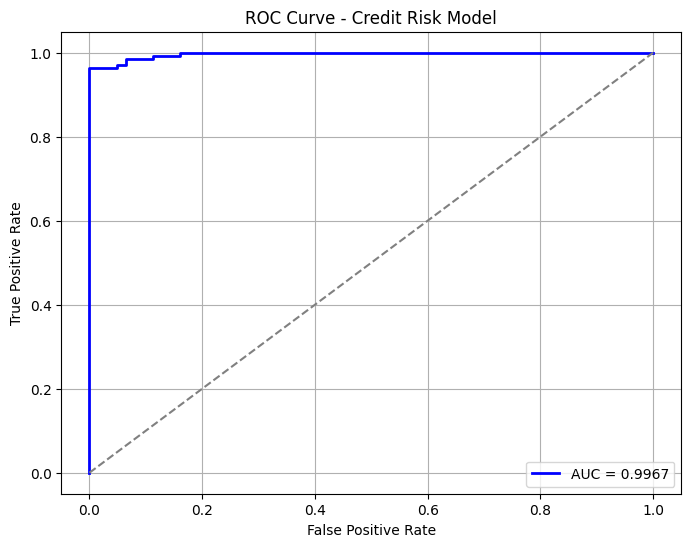

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (default = 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="blue", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Risk Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Interpreation of ROC curve**

The ROC curve is threshold-independent, which makes it great for model evaluation in credit risk.


In this case, AUC: 0.9967 is closer to 1.

An AUC of 1.0 = perfect, 0.5 = random.

The closer the curve is to the top-left corner, the better.




**Next, apply SHAP to explain the model's predictions**:

In [7]:
explainer = shap.Explainer(model) #creates a SHAP Explainer that understands the LightGBM model
shap_values = explainer(X_test) #computes SHAP values for every prediction in test set


**SHAP values** tell how much each feature pushes each prediction i.e.,  how much each feature contributes to a particular prediction.

- A SHAP value > 0 → pushes the prediction toward default (i.e., higher risk)

- A SHAP value < 0 → pushes it away from default (i.e., lower risk)

**SHAP Visualizations**:


**1) SHAP Summary (Bar) Plot**:

It shows which features most influence the model's predictions:

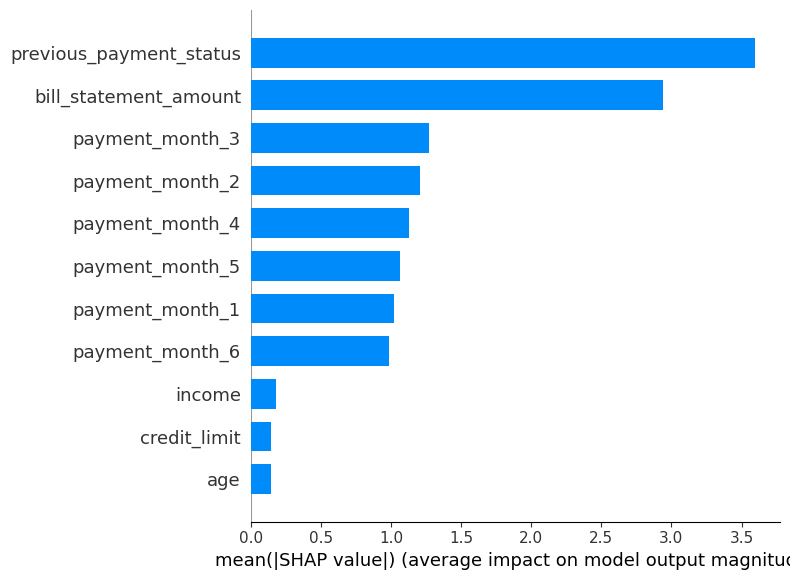

In [8]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Interpretation of SHAP Bar plot**


SHAP bar plot is based on the mean absolute SHAP value - it is a ranked list of features based on their overall importance in the model. That is, it tells which features matter most overall!


Each bar represents a feature:
The length of the bar = average impact of that feature on the model’s predictions.
The y-axis = feature names, ranked from most to least important.
The x-axis = mean absolute SHAP value (i.e., how much that feature contributed to predictions on average).

Remark: A SHAP bar plot only shows feature importance, not direction - it doesn’t tell how the feature affects the prediction. That is, it tells what features does the model pay the most attention to, regardless of whether it pushes the prediction up or down!

The SHAP Bar plot is useful for **feature selection**, also for model debugging, and explaining what the model cares about - for example, in reports or compliance docs - where simplicity and clarity are key.

While SHAP bar plot tells *what’s important*, the dot plot tells *what’s happening* - it is used to answer questions e.g., What’s the impact of high vs. low values feature on the model prediction


 **2)SHAP Dot Plot (Beeswarm)**:

 It shows both importance and direction:


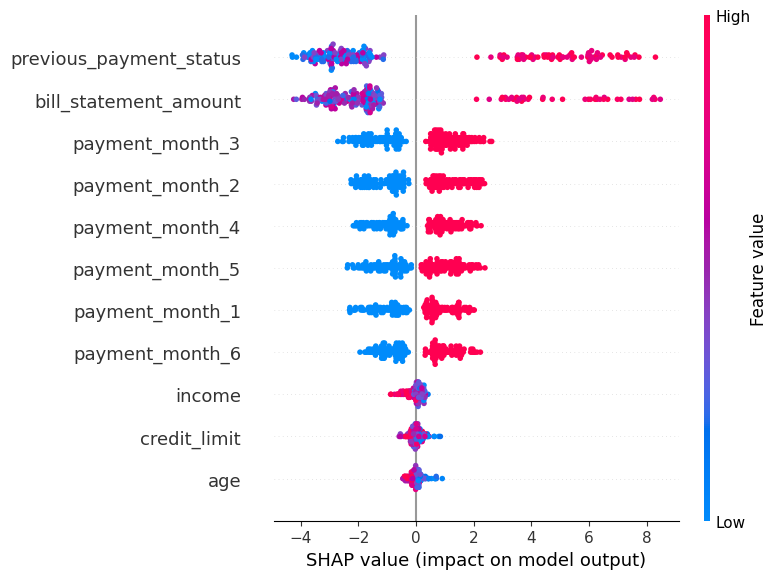

In [9]:
shap.summary_plot(shap_values, X_test, plot_type="dot")


**Interpretation of the SHAP dot plot**:


→ Right = increases prediction (e.g., higher credit risk)
→ Left = decreases prediction (e.g., lower credit risk)

The color:actual value of the feature for each person

→ Red = high feature value (e.g., high income or high bill amount)
→ Blue = low feature value

Vertical spread: how varied the SHAP values are for that feature

→ More spread = more complex or inconsistent effect across customers



**3)Force Plot**

explains how the model made one prediction by showing how each feature pushed the prediction up or down from the model’s base value (the average prediction):

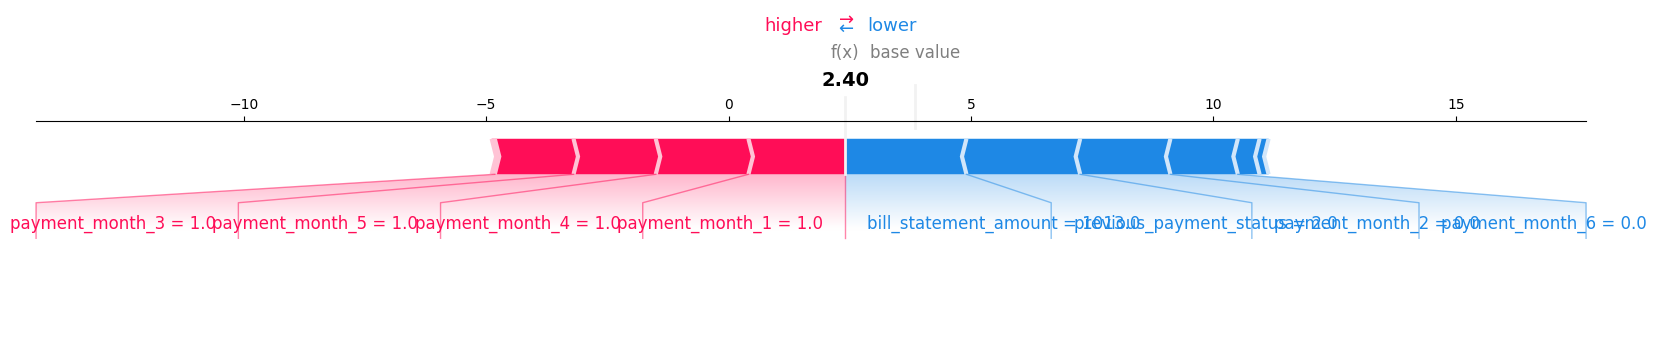

<IPython.core.display.HTML object>

In [10]:
from IPython.display import HTML

HTML(shap.plots.force(shap_values[0], matplotlib=True))



**Interpreation of SHAP force plot**:

Here, `shap_values[0]` refers to the SHAP values for the **first instance** (or customer) in the `X_test` set.

The force plot shows how each feature contributes to the prediction for this specific customer.
  - **Red** features increase the prediction (toward a higher default risk).
  - **Blue** features decrease the prediction (toward a lower default risk).
  
In simple terms, SHAP force plot for this first customer explains **why** the model predicted a particular risk level.

It shows **how each feature (e.g., monthly payment history)** affected the final prediction, with some features pushing the risk **up** (red) and others pushing it **down** (blue)."

For this first customer, you may see:
- Payment history (month 1,3,4,5) (**red**) increases the risk prediction.
- Bill amount, Payment history (month 2)(**blue**) decreases the risk prediction.

The combined effect from all features results in the final risk score (e.g., 3.30).

A force plot can be used to explains the model’s decision for a single customer in an easy-to-understand visual format.


**Summary**:

In this project, we built a credit risk model using LightGBM to predict whether a customer is at risk of defaulting on a loan.

We then applied SHAP to explain the model's predictions and ensure transparency and fairness. SHAP provides clear insights into which features influence the model’s decision-making process.

By using SHAP with the LightGBM model, we can explain individual predictions, understand feature importance, and ensure fairness in credit risk assessments.

The 3 SHAP plots: bar, dot and force plot — provide a clear, comprehensive view of the model’s decision-making process. These insights are crucial for model interpretation, and increasing trust in automated decisions.
